In [1]:
# PACS details
domains = ['photo', 'art_painting', 'cartoon', 'sketch']
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse','house', 'person']

# Set parameters

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torchvision.datasets as Datasets
from torchvision import models
from torchvision.datasets import ImageFolder, DatasetFolder

from utils import *
import os

import numpy as np
import matplotlib.pyplot as plt

from model.resnet18_selfreg import resnet18


In [3]:
##############################
# Training Setting
##############################

# Select model to train
# resnet18(pytorch official):'resnet18_classic'
# SelfReg : 'resnet18' 
used_model = 'resnet18'
save_name = 'SelfReg_official_test_1'     # save_dir name
                                        # save_path : resnet_18/pacs/{save_name}/
dataset ='pacs'        
pacs_ver = 'pacs_official_split' 
number_of_tests = 1
gpu_num = 1
n_workers = 6

##############################
# Basic Hyper-parameters
##############################

# is_selfreg = True  # use selfreg?
# is_idcl = True # use IDCL?
is_selfreg = False  # use selfreg?
is_idcl = False # use IDCL?

epochs = 30
batch_size = 128
is_pretrained = True  # Use ImageNet pretrain weight ?
used_optimizer = 'SGD' # 'Adam' or 'SGD'

#Learning rate
lr = 4e-3 
lr_decay_epoch = [100]
lr_decay_gamma = 0.1


train_tf, test_tf = get_tf(augment=True)


In [4]:
device = torch.device("cpu")
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    device = torch.device("cuda:{}".format(gpu_num))
print(device)

# save settings
model_settings = {
    "used_model": used_model,
    "dataset": dataset,
    "save_name": save_name,
    "pacs_ver": pacs_ver,
    "number_of_tests": number_of_tests,
    "epochs": epochs,
    "batch_size": batch_size,
    "is_pretrained": is_pretrained,
    "lr": lr,
    "lr_decay_epoch": lr_decay_epoch,
    "lr_decay_gamma": lr_decay_gamma,
    "gpu_num": gpu_num,
}

criterion = nn.CrossEntropyLoss().to(device)
#criterion = nn.NLLloss().to(device)

Using CUDA
cuda:1


# Functions

In [5]:

def classic_setting(
    test_domain_idx,
    domains,
    batch_size,
    is_pretrained,
    train_tf,
    test_tf,
    used_model,
    pacs_ver,
    used_optimizer,
):

    train_set1 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 1) % len(domains)]
        ),
        transform=train_tf,
    )
    train_set2 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 2) % len(domains)]
        ),
        transform=train_tf,
    )
    train_set3 = ImageFolder(
        root=os.path.join(
            "{}/train".format(pacs_ver), domains[(test_domain_idx + 3) % len(domains)]
        ),
        transform=train_tf,
    )

    val_set1 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 1) % len(domains)]
        ),
        transform=test_tf,
    )
    val_set2 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 2) % len(domains)]
        ),
        transform=test_tf,
    )
    val_set3 = ImageFolder(
        root=os.path.join(
            "{}/val".format(pacs_ver), domains[(test_domain_idx + 3) % len(domains)]
        ),
        transform=test_tf,
    )

    train_set = train_set1 + train_set2 + train_set3
    val_set = val_set1 + val_set2 + val_set3
    test_set = ImageFolder(
        root=os.path.join("{}/test".format(pacs_ver), domains[test_domain_idx]),
        transform=test_tf,
    )

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=n_workers
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers=n_workers
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=n_workers
    )

    if used_model == "vgg16":
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features = len(classes)
    elif used_model == "inceptionv3":
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = len(classes)
        model.fc.out_features = len(classes)
    # 해당 코드 바꾸면 될듯? resnet18 부분..
    elif used_model == "resnet18":
        # load weights pretrained on ImageNet
        model = resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(classes))
        model = model.to(device)
    elif used_model == "resnet18_classic":
        model = models.resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(classes))
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError

    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_decay_epoch, gamma=lr_decay_gamma
    )

    settings = {
        "train_loaders": train_loader,
        "val_loaders": val_loader,
        "optimizer": optimizer,
        "model": model,
        "lr_scheduler": scheduler,
        "swa_model": swa_model,
        "swa_scr": swa_scr,
    }

    return settings, test_loader


def IDCL_setting(
    test_domain_idx,
    domains,
    batch_size,
    is_pretrained,
    train_tf,
    test_tf,
    used_model,
    pacs_ver,
    used_optimizer,
):

    check = 1
    train_set = 0
    val_set = 0
    check_limit = 3

    for i in range(4):
        if check > check_limit:
            break
        if i == test_domain_idx:
            continue

        temp = ImageFolder(
            root=os.path.join("{}/train".format(pacs_ver), domains[i]),
            transform=train_tf,
        )

        temp_val = ImageFolder(
            root=os.path.join("{}/val".format(pacs_ver), domains[i]), transform=test_tf
        )
        if check == 1:
            train_set = temp
            val_set = temp_val
        else:
            train_set += temp
            val_set += temp_val

        if check == 1:
            train_set_stage1 = train_set
            val_set_stage1 = val_set
        elif check == 2:
            train_set_stage2 = train_set
            val_set_stage2 = val_set
        elif check == 3:
            train_set_stage3 = train_set
            val_set_stage3 = val_set

        check += 1

    test_set = ImageFolder(
        root=os.path.join("{}/test".format(pacs_ver), domains[test_domain_idx]),
        transform=test_tf,
    )

    print("stage1 (train,val):", len(train_set_stage1), len(val_set_stage1))
    print("stage2 (train,val):", len(train_set_stage2), len(val_set_stage2))
    print("stage3 (train,val):", len(train_set_stage3), len(val_set_stage3))
    print("test :", len(test_set))

    t_loader1 = DataLoader(
        train_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader1 = DataLoader(
        val_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6
    )

    t_loader2 = DataLoader(
        train_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader2 = DataLoader(
        val_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6
    )

    t_loader3 = DataLoader(
        train_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6
    )
    v_loader3 = DataLoader(
        val_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6
    )

    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=6
    )

    if used_model == "vgg16":
        print("vgg16")
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features = 7
    elif used_model == "inceptionv3":
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = 7
        model.fc.out_features = 7
    elif used_model == "resnet18":
        model = resnet18(pretrained=is_pretrained,c = 0.01, clip_r = 2)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)
        model = model.to(device)
    elif used_model == "resnet18_classic":
        model = models.resnet18(pretrained=is_pretrained)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 7)
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError

    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_decay_epoch, gamma=lr_decay_gamma
    )

    train_loaders = [t_loader1, t_loader2, t_loader3]
    val_loaders = [v_loader1, v_loader2, v_loader3]

    settings = {
        "train_loaders": train_loaders,
        "val_loaders": val_loaders,
        "optimizer": optimizer,
        "model": model,
        "lr_scheduler": scheduler,
        "swa_model": swa_model,
        "swa_scr": swa_scr,
    }

    return settings, test_loader



# Automation

save_dir resnet18/pacs/SelfReg_official_test_1/photo+art_painting+cartoon(sketch)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.2289
epoch: 1
Validation ==================================================
Avg acc (val): 0.4627
epoch: 2
Validation ==================================================
Avg acc (val): 0.5698
epoch: 3
Validation ==================================================
Avg acc (val): 0.6185
epoch: 4
Validation ==================================================
Avg acc (val): 0.7354
epoch: 5
Validation ==================================================
Avg acc (val): 0.8360
epoch: 6
Validation ==================================================
Avg acc (val): 0.8555
epoch: 7
Validation ==================================================
Avg acc (val): 0.8458
epoch: 8
Validation ==================================================
Avg acc (val): 0.8685
epoch: 9
Validation ==============================================

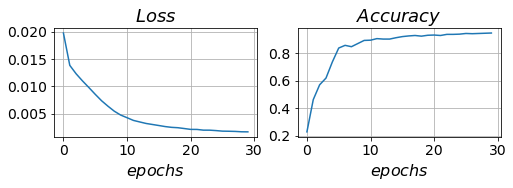

save_dir resnet18/pacs/SelfReg_official_test_1/photo+art_painting+sketch(cartoon)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.3076
epoch: 1
Validation ==================================================
Avg acc (val): 0.4595
epoch: 2
Validation ==================================================
Avg acc (val): 0.6525
epoch: 3
Validation ==================================================
Avg acc (val): 0.7426
epoch: 4
Validation ==================================================
Avg acc (val): 0.8005
epoch: 5
Validation ==================================================
Avg acc (val): 0.8366
epoch: 6
Validation ==================================================
Avg acc (val): 0.8546
epoch: 7
Validation ==================================================
Avg acc (val): 0.8687
epoch: 8
Validation ==================================================
Avg acc (val): 0.8880
epoch: 9
Validation ==============================================

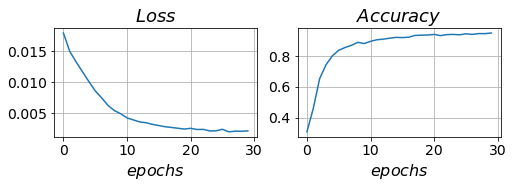

save_dir resnet18/pacs/SelfReg_official_test_1/photo+cartoon+sketch(art_painting)/
device cuda:1
epoch: 0
Validation ==================================================
Avg acc (val): 0.3052
epoch: 1
Validation ==================================================
Avg acc (val): 0.5521
epoch: 2
Validation ==================================================
Avg acc (val): 0.6811
epoch: 3
Validation ==================================================
Avg acc (val): 0.7345


In [ ]:
is_selfreg = False
save_model_setting(model_settings, used_model, domains, dataset, save_name)
set_train = IDCL_setting if is_idcl else classic_setting
temp_dict = {
    "device": device,
    "epochs": epochs,
    "criterion": criterion,
    "is_selfreg": is_selfreg,
    "is_idcl": is_idcl,
}

for i in range(1, number_of_tests + 1):
    try_check = i

    for test_idx in [3, 2, 1, 0]:

        ##########################
        ####   Setting Train  ####
        ##########################

        model_sets = [
            test_idx,
            domains,
            batch_size,
            is_pretrained,
            train_tf,
            test_tf,
            used_model,
            pacs_ver,
            used_optimizer,
        ]
        train_settings, test_loader = set_train(*model_sets)
        train_settings.update(temp_dict)

        save_dir = save_route(test_idx, domains, dataset, save_name, used_model)
        print("save_dir", save_dir)

        try:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        except:
            print("Error : Creating directory. " + save_dir)

        ##########################
        ####     Training     ####
        #####################p#####

        model, losses, accuracies = train(**train_settings)
        test_accuracy = test(
            device, model, criterion, test_loader, used_model, save_dir, try_check
        )

        total_result_text_path = os.path.join(save_dir, "test_total_result.txt")
        with open(total_result_text_path, "a") as f:
            print(test_accuracy)
            f.write(str(test_accuracy) + "\n")

        plotting(losses, accuracies, used_model, save_dir, is_pretrained, try_check)
#         save_model(model, used_model, save_dir, is_pretrained, try_check)
        